In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import tensorflow as tf

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import math

## Parameters

In [5]:
NSAMPLE = 2500

In [6]:
from aml_dl.mdn.training.config import network_params_inv

In [7]:
from aml_dl.mdn.model.mdn_push_inv_model import MDNPushInverseModel

In [8]:
from aml_data_collec_utils.core.data_manager import DataManager

/home/mjm/gitlibs/aml_data/aml_dl/baxter_push_data/


In [9]:
sess = tf.InteractiveSession()

In [10]:
inverse_model = MDNPushInverseModel(sess=sess, network_params=network_params_inv)
inverse_model.init_model()

In [11]:
x_curr   = np.random.randn(1,7).tolist()[0]
x_tgt    = np.random.randn(1,7).tolist()[0]
u_action = np.random.random((1,2))

In [12]:
input_x = np.expand_dims(np.r_[x_curr, x_tgt], 0)
mus = inverse_model.run_op('mu', input_x)[0]
sigma = inverse_model.run_op('sigma', input_x)[0]
pis = inverse_model.run_op('pi', input_x)[0]
loss = inverse_model._mdn.run_op(sess,'loss', xs = input_x, ys = u_action)[0]

print "MUS: ", mus
print "SIGMA: ", sigma
print "PIs:", pis
print "LOSS:", loss
#theta = inverse_model.sample_out_max_pi(input_x, 1)[0]
    
pi_idx = inverse_model._max_pi_idx(pis)

action = mus[:,pi_idx]


MUS:  [[ 0.00688897 -0.02573361  0.12317345  0.12438294  0.00382894]
 [ 0.30230099  0.20251933  0.27086458  0.05781738 -0.33486333]]
SIGMA:  [ 1.37799644  1.30880666  1.16822231  1.32044673  1.06421614]
PIs: [ 0.16776749  0.20425679  0.24374095  0.19653347  0.1877013 ]
LOSS: [[ 2.16483474]]


In [13]:
network_params_inv['dim_input'] = 14
network_params_inv['dim_output'] = 2
network_params_inv['k_mixtures'] = 24

inverse_model = MDNPushInverseModel(sess=sess, network_params=network_params_inv)
inverse_model.init_model()

In [14]:
data_file_indices = network_params_inv['train_file_indices']

data_man = DataManager(data_folder_path=network_params_inv['training_data_path'], data_name_prefix='test_push_data')

In [15]:
ids=range(0,5)
y_keys = ['task_action']
x_keys = ['box_pos', 'box_ori']
x_sub_keys = [[None],[None]]
y_sub_keys = [['push_xz']]

data_x1 = data_man.pack_data_in_range(keys=x_keys, sub_keys=x_sub_keys, ids=ids, sample_points=[0], data_file_range=data_file_indices)
data_x2 = data_man.pack_data_in_range(keys=x_keys, sub_keys=x_sub_keys, ids=ids, sample_points=[-1], data_file_range=data_file_indices)
data_y  = data_man.pack_data_in_range(keys=y_keys, sub_keys=y_sub_keys, ids=ids,  sample_points=[0], data_file_range=data_file_indices)

data_x  = np.hstack([np.asarray(data_x1),np.asarray(data_x2)]).tolist()

print data_x[0]
print "Data y"
print data_y[0]

[0.48422095567747897, 0.5086423553144893, -0.49989509662481596, -0.5068707062292948, 0.7772083686903487, 0.00968411455251833, -0.10059531962601909, 0.574241039738017, 0.5904788994700245, -0.3995292523324805, -0.40244039818576793, 0.7534997174850996, 0.0754617492055675, -0.09852676853956521]
Data y
[ 0.          0.00341609]


In [16]:
data_y

[array([ 0.        ,  0.00341609]),
 array([ 0.        , -0.01872924]),
 array([-0.00201198,  0.        ]),
 array([-0.02138302,  0.        ]),
 array([ 0.        ,  0.00075762]),
 array([ 0.        , -0.00488879]),
 array([ 0.00159567,  0.        ]),
 array([-0.03031349,  0.        ]),
 array([ 0.        , -0.00294905]),
 array([ 0.        ,  0.02536172]),
 array([ 0.01488195,  0.        ]),
 array([ 0.        ,  0.00709806]),
 array([ 0.        , -0.02106802]),
 array([-0.02504312,  0.        ]),
 array([ 0.02784846,  0.        ]),
 array([ 0.        , -0.01843579]),
 array([ 0.01454813,  0.        ]),
 array([ 0.01573059,  0.        ]),
 array([ 0.        ,  0.00311425]),
 array([ 0.        ,  0.02672056]),
 array([-0.01763859,  0.        ]),
 array([ 0.        ,  0.01337891]),
 array([ 0.       ,  0.0265686]),
 array([ 0.0114942,  0.       ]),
 array([ 0.0020253,  0.       ]),
 array([ 0.       , -0.0109853]),
 array([ 0.0155405,  0.       ]),
 array([-0.01083585,  0.        ]),
 a

In [17]:
xs = data_x#np.random.uniform(-10.5, 10.5, (14, NSAMPLE)).T
ys = data_y#np.random.uniform(-10.5, 10.5, (2, NSAMPLE)).T

In [18]:
sess.run(tf.global_variables_initializer())

NEPOCH = 10000
loss = inverse_model.train(x_data = xs, y_data = ys, epochs =  NEPOCH)

In [19]:
print loss

[ 1.85004139  1.8466624   1.84328389 ..., -2.46455073 -2.44638944
 -2.45034075]


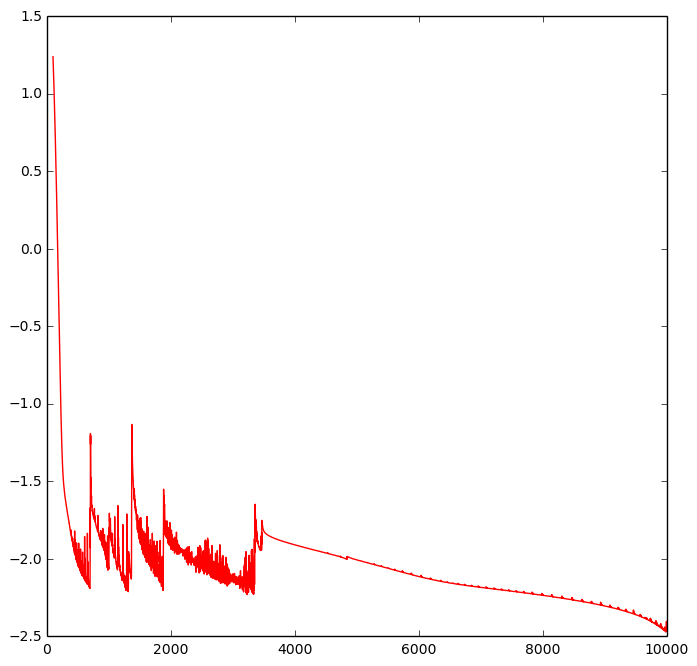

In [20]:
plt.figure(figsize=(8, 8))
plt.plot(np.arange(100, NEPOCH,1), loss[100:], 'r-')
plt.show()

In [21]:
from aml_dl.mdn.model.tf_mdn_model import MixtureOfGaussians

In [22]:
out_pi = inverse_model._net_ops['pi']
out_sigma = inverse_model._net_ops['sigma']
out_mu = inverse_model._net_ops['mu']
x = inverse_model._net_ops['x']

In [24]:
mixture = MixtureOfGaussians()

In [25]:
x_test = np.float32(np.arange(-15,15,0.1))
NTEST = x_test.size
x_test = x_test.reshape(NTEST,1) # needs to be a matrix, not a vector


In [26]:
out_pi_test, out_sigma_test, out_mu_test = sess.run([out_pi, out_sigma, out_mu], feed_dict={x: x_test})

ValueError: Cannot feed value of shape (300, 1) for Tensor u'x_1:0', which has shape '(?, 14)'

In [ ]:
out_mu_test = out_mu_test.reshape((300,24))
print out_pi_test.shape, x_test.shape, out_sigma_test.shape, out_mu_test.shape


In [ ]:
# print out_mu_test.reshape((300,2))

In [ ]:


y_test = mixture.generate_mixture_samples(out_pi_test, out_mu_test, out_sigma_test,100)

plt.figure(figsize=(8, 8))
plt.plot(x_data,y_data,'ro', x_test,y_test,'bo',alpha=0.3)
plt.show()